# Recurrent Neural Network (RNN)

### We started by importing relevant libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import librosa.display
import librosa

import os
import struct
from scipy.io import wavfile as wav
import IPython.display as ipd
from tqdm import tqdm
import warnings

import glob
import soundfile as sf
from tqdm import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, concatenate,GRU, LSTM, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax, Adam
import keras
from keras.utils import plot_model
from sklearn.metrics import *
from seaborn import heatmap, barplot

from datetime import datetime

import pickle


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

warnings.filterwarnings("ignore")

### Loading the data generated by feature extraction

In [3]:
#   reload pickled data from file
with open('X_mfcc.pkl', 'rb') as f:
    X_mfcc = pickle.load(f)

with open('X_chroma.pkl', 'rb') as f:
    X_chroma = pickle.load(f)

with open('Y.pkl', 'rb') as f:
    Y = pickle.load(f)

X_mfcc_data = np.array(X_mfcc)
X_chroma_data = np.array(X_chroma)
Y_data = np.array(Y)

### Transforming data to fit the model

In [4]:
X_mfcc_rnn = []
X_chroma_rnn = []
Y = []
for i in range(10):
  xi_mfcc_rnn = np.array(X_mfcc_data[i])
  xi_mfcc_rnn = np.reshape(xi_mfcc_rnn,(xi_mfcc_rnn.shape[0],xi_mfcc_rnn.shape[1],xi_mfcc_rnn.shape[2]))
  X_mfcc_rnn.append(xi_mfcc_rnn)

  xi_chroma_rnn = np.array(X_chroma_data[i])
  xi_chroma_rnn = np.reshape(xi_chroma_rnn,(xi_chroma_rnn.shape[0],xi_chroma_rnn.shape[1],xi_chroma_rnn.shape[2]))
  X_chroma_rnn.append(xi_chroma_rnn)

  yi = to_categorical(Y_data[i], num_classes=10)
  Y.append(yi)

### Creating the model

In [5]:
# Recurrent layers are the ideal ones for this kind of output, so we don't feel the need to have more dense layers after that
# Then we add one more layer to concatenate both inputs into the activation function's input

def get_model_rnn():
  input1 = Input(shape=X_mfcc_rnn[0][0].shape, name='MFCC Input')
  input1_rec_layers = GRU(512, kernel_regularizer = regularizers.l2(l=0.2), kernel_initializer='he_normal')(input1)

  input2 = Input(shape=X_chroma_rnn[0][0].shape,name='Chromagram Input')
  input2_rec_layers = GRU(512, kernel_regularizer = regularizers.l2(l=0.2), kernel_initializer='he_normal')(input2)

  rec_out = concatenate([input1_rec_layers, input2_rec_layers])

  output = Dense(10, activation='softmax', kernel_initializer='Ones')(rec_out)

  model = Model(inputs=[input1, input2], outputs=[output])
  model.compile(optimizer=Adam(),loss="categorical_crossentropy",metrics=["accuracy"])

  return model

### DeepFool

In [6]:
# calculate the gradient for a certain x_i value of an input's prediction
def get_gradient(model, x_i, k):
    with tf.GradientTape(persistent=True) as tape:
        inputs = [tf.cast(input_value, dtype=tf.float64) for input_value in x_i]
        for input_value in inputs:
            tape.watch(input_value)
        results = model(inputs)
        results_k = results[0,k]

    gradients = tape.gradient(results_k, inputs)
    del tape
    # return the gradient in numpy.array form for ease of future calculations
    return np.array([grad.numpy() for grad in gradients])

def deepfool(x,model,max_iter,overshoot=0.02):
    erro = False
    iter = 0
    final_r = 0
    pred_original = np.argmax(model(x), axis=1)[0]
    r = []

    while pred_original == np.argmax(model(x), axis=1) and iter<max_iter:
        w_min = np.zeros(max_iter)
        f_min = np.zeros(max_iter)
        argmin = np.inf
        grad_flabel = get_gradient(model,x,pred_original)

        # find the minimal parameters w and f needed to calculate r
        for pred in range(10):
            if pred_original == pred:
                continue
            w = get_gradient(model,x,pred) - grad_flabel
            f = model(x)[0][pred] - model(x)[0][pred_original]
            if abs(f)/np.linalg.norm(w) < argmin:
                argmin = abs(f)/(np.linalg.norm(w) + 0.00001)   # we sum 0.00001 in case w = 0
                w_min = w
                f_min = f

        # minimal perturbation calculation 
        r = abs(f)/(np.linalg.norm(w)**2 + 0.00001) * w_min
        
        # add the minimal perturbation vector r found on the iteration to the total change vector final_r
        final_r += r

        # add the perturbation to the input and store it for possible future input to the model
        x += r * (1+overshoot)
        x = [np.array([x[0][0]]),np.array([x[1][0]])]
        iter += 1

        # if no changes were made in the maximum number of iterations, consider the adversarial attack a failed one
        if iter == max_iter-1:
            erro = True

    return final_r,erro

def get_perturbation(x,model,max_iter):
    x_norm = np.linalg.norm(x)

    # obtain the minimal perturbation needed to misclassify an input using the DeepFool algorythm
    r = deepfool(x,model,max_iter)

    if r[1]:
      return -1     # if no perturbations were made then we don't consider the case
    
    r = np.array(r[0][0][0]),np.array(r[0][1][0])
    r_norm = np.linalg.norm(r)

    # calculate the perturbation value for further use
    pert = r_norm/x_norm

    return pert

### Training and evaluating models

Epoch 1/30
55/55 [==============================] - 12s 50ms/step - loss: 830.2145 - accuracy: 0.2773 - val_loss: 508.8954 - val_accuracy: 0.3457
Epoch 2/30
55/55 [==============================] - 2s 30ms/step - loss: 339.2407 - accuracy: 0.4674 - val_loss: 205.6214 - val_accuracy: 0.4426
Epoch 3/30
55/55 [==============================] - 2s 31ms/step - loss: 135.3906 - accuracy: 0.5840 - val_loss: 80.6648 - val_accuracy: 0.5056
Epoch 4/30
55/55 [==============================] - 2s 33ms/step - loss: 52.2355 - accuracy: 0.6336 - val_loss: 30.8591 - val_accuracy: 0.4989
Epoch 5/30
55/55 [==============================] - 2s 33ms/step - loss: 19.6529 - accuracy: 0.6488 - val_loss: 11.9300 - val_accuracy: 0.4595
Epoch 6/30
55/55 [==============================] - 2s 32ms/step - loss: 7.5480 - accuracy: 0.6589 - val_loss: 5.0829 - val_accuracy: 0.4561
Epoch 7/30
55/55 [==============================] - 2s 30ms/step - loss: 3.2631 - accuracy: 0.6883 - val_loss: 2.8424 - val_accuracy: 0.47

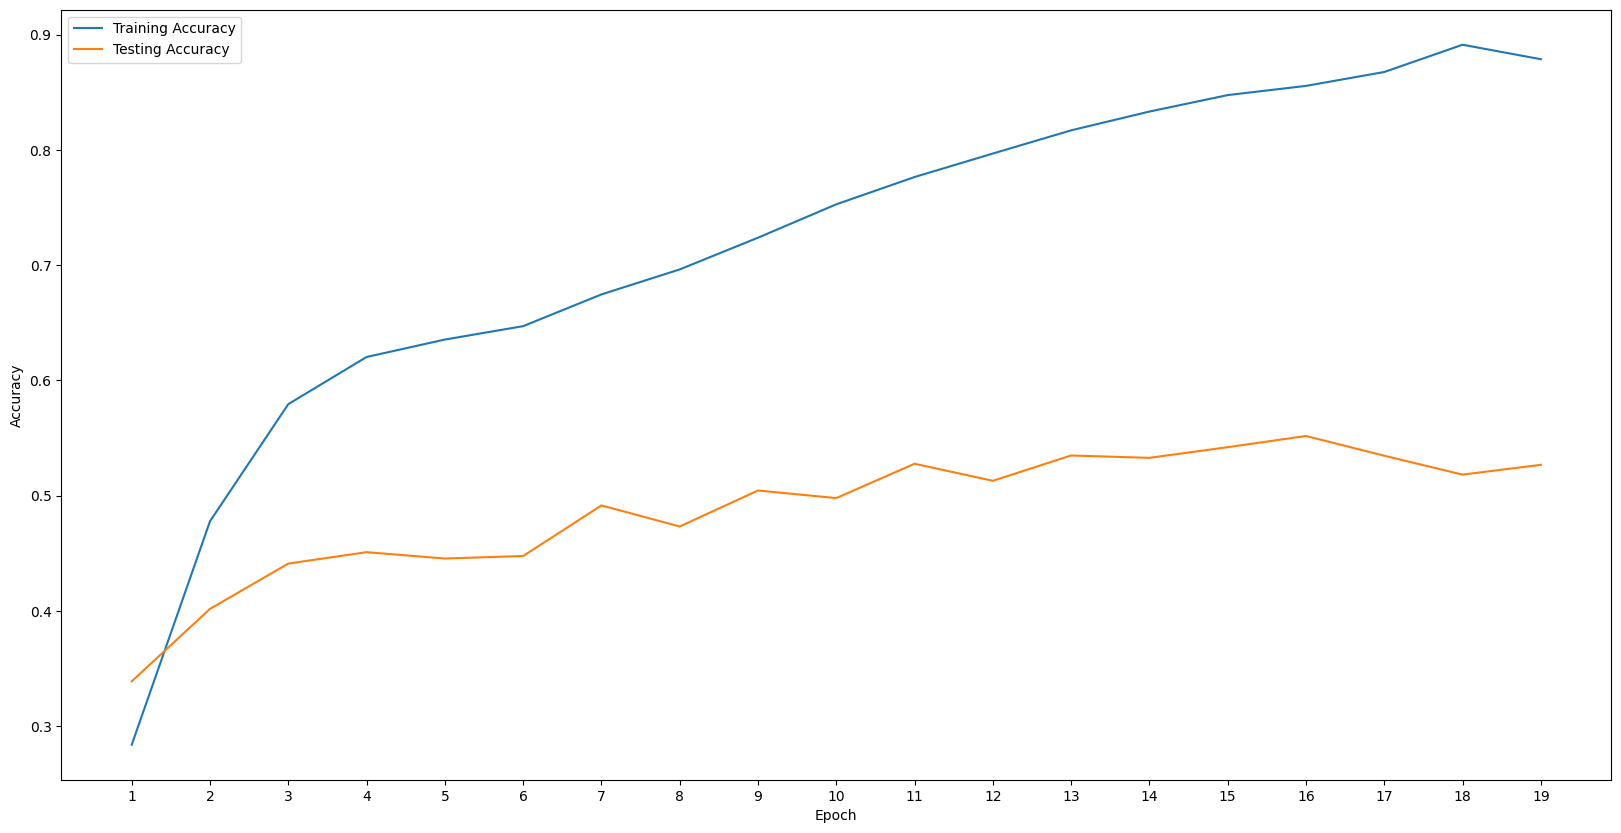

In [7]:
epochs = 30
best_accuracy_rnn = 0
best_model_rnn = 0
prediction_rnn = []
label_rnn = []
accuracy_rnn = np.zeros(epochs)
val_accuracy_rnn = np.zeros(epochs)
folds_per_epoch = np.full(epochs, 10, dtype=int)
test_accuracy = []
test_loss = []
total_peturbation = 0
count_fool_success = 0

# for each fold we create a different model, that trains in 8 other folds, uses the other 1 as validation data and that one for test data
for i in range(10):
  v = i%9 +1
  model = get_model_rnn()

  x_mfcc_train = np.concatenate([X_mfcc_rnn[j] for j in [k for k in range(10) if k not in [i,v]]])
  x_chroma_train = np.concatenate([X_chroma_rnn[j] for j in [k for k in range(10) if k not in [i,v]]])
  y_train = np.concatenate([Y[j] for j in [k for k in range(10) if k not in [i,v]]])

  x_mfcc_validation = X_mfcc_rnn[v]
  x_chroma_validation = X_chroma_rnn[v]
  y_validation = Y[v]

  x_mfcc_test = X_mfcc_rnn[i]
  x_chroma_test = X_chroma_rnn[i]
  y_test = Y[i]

  history_rnn = model.fit([x_mfcc_train,x_chroma_train], y_train,  validation_data = ([x_mfcc_validation,x_chroma_validation], y_validation),epochs=epochs, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=5)])

  # store the training process so we can analyse it later
  for k in range(epochs-len(history_rnn.history['accuracy'])):
    folds_per_epoch[epochs-1-k] -= 1
  temp = np.zeros(epochs-len(history_rnn.history['accuracy']))
  acc = np.append(np.array(history_rnn.history['accuracy']),temp)
  val_acc = np.append(np.array(history_rnn.history['val_accuracy']),temp)
  accuracy_rnn = accuracy_rnn + acc
  val_accuracy_rnn = val_accuracy_rnn + val_acc

  #get the results of using our model on test data
  test_pred = model.predict([x_mfcc_test,x_chroma_test])
  test_eval= model.evaluate([x_mfcc_test,x_chroma_test], y_test)
  prediction_rnn.append(test_pred)
  label_rnn.append(y_test)

  print("Results for folder: ", i+1)
  print(f"Loss: {test_eval[0]}   Accuracy: {test_eval[1]}")

  test_loss.append(test_eval[0])
  test_accuracy.append(test_eval[1])

  if test_eval[1]>best_accuracy_rnn:
    best_accuracy_rnn = test_eval[1]
    best_model_rnn = model

  # using deepfool to check the robustness of the model
  print(f"Calculating peturbations using deepfool for fold {i+1}")

  for line in range(len(Y[i])):
    X = [np.array([X_mfcc_rnn[i][line]]),np.array([X_chroma_rnn[i][line]])]
    peturbation = get_perturbation(x=X, model=model,max_iter=20)
    if peturbation != -1:
      total_peturbation += peturbation
      count_fool_success += 1

# using the data from the 10 models
for i in range(len(folds_per_epoch)):
  accuracy_rnn[i] /= folds_per_epoch[i]
  val_accuracy_rnn[i] /= folds_per_epoch[i]
test_loss = np.array(test_loss)
test_accuracy = np.array(test_accuracy)
print("RNN Average Test Loss: ", test_loss.mean())
print("RNN Standart Deviation Test Loss: ", test_loss.std())
print("RNN Average Test Accuracy: ", test_accuracy.mean())
print("RNN Standart Deviation Test Accuracy: ", test_loss.std())
print("RNN Best Accuracy: ", best_accuracy_rnn)
print(f"The average peturbation to change the prediction of the model was {total_peturbation/count_fool_success}")
plt.figure(figsize=(20, 10))
plt.plot(accuracy_rnn, label='Training Accuracy')
plt.plot(val_accuracy_rnn, label='Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
max = epochs
while folds_per_epoch[max-1] == 0:
  max -= 1
plt.xticks(np.arange(max), np.arange(1, max+1))
plt.legend()
plt.show()

# saving one of the models
pickle.dump(best_model_rnn , open('RNN.pkl' , 'wb'))

### Plotting the model to have a better understanding of how it works

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MFCC Input (InputLayer)     [(None, 40, 174)]            0         []                            
                                                                                                  
 Chromagram Input (InputLay  [(None, 40, 174)]            0         []                            
 er)                                                                                              
                                                                                                  
 gru_18 (GRU)                (None, 512)                  1056768   ['MFCC Input[0][0]']          
                                                                                                  
 gru_19 (GRU)                (None, 512)                  1056768   ['Chromagram Input[0][0]

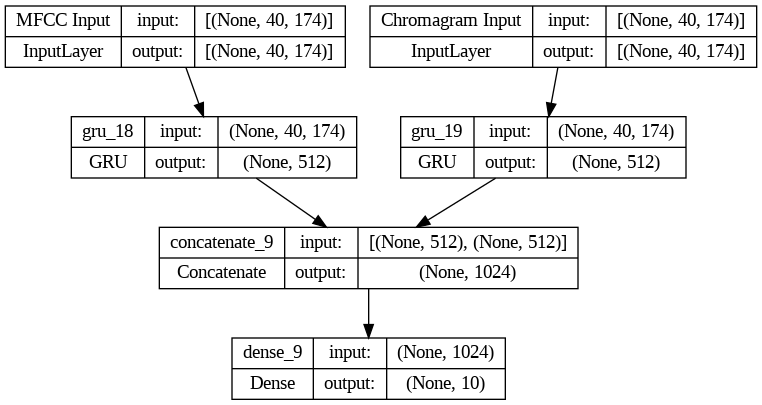

In [8]:
best_model_rnn.summary()
plot_model(best_model_rnn, show_shapes=True)

### Check the model's prediction against the correct label to further evaluate the models

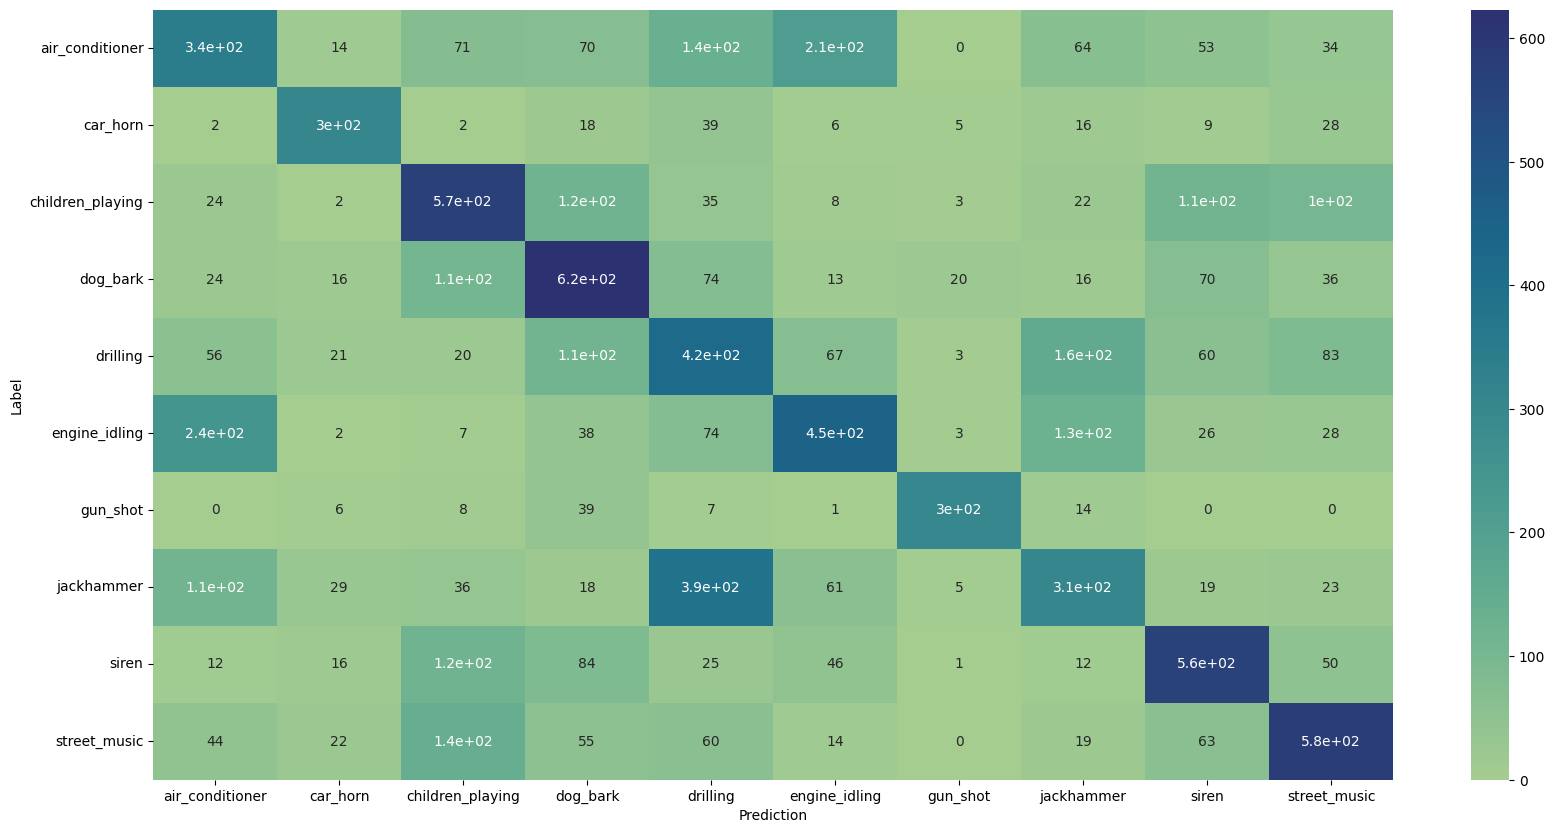

              precision    recall  f1-score   support

           0       0.40      0.34      0.37      1000
           1       0.70      0.71      0.71       429
           2       0.53      0.57      0.55      1000
           3       0.53      0.62      0.57      1000
           4       0.33      0.42      0.37      1000
           5       0.51      0.45      0.48      1000
           6       0.88      0.80      0.84       374
           7       0.41      0.31      0.35      1000
           8       0.58      0.61      0.59       929
           9       0.60      0.58      0.59      1000

    accuracy                           0.51      8732
   macro avg       0.55      0.54      0.54      8732
weighted avg       0.51      0.51      0.51      8732

Balanced Accuracy: 0.5414270788878907


Cohen’s Kappa Score: 0.4525508350843044




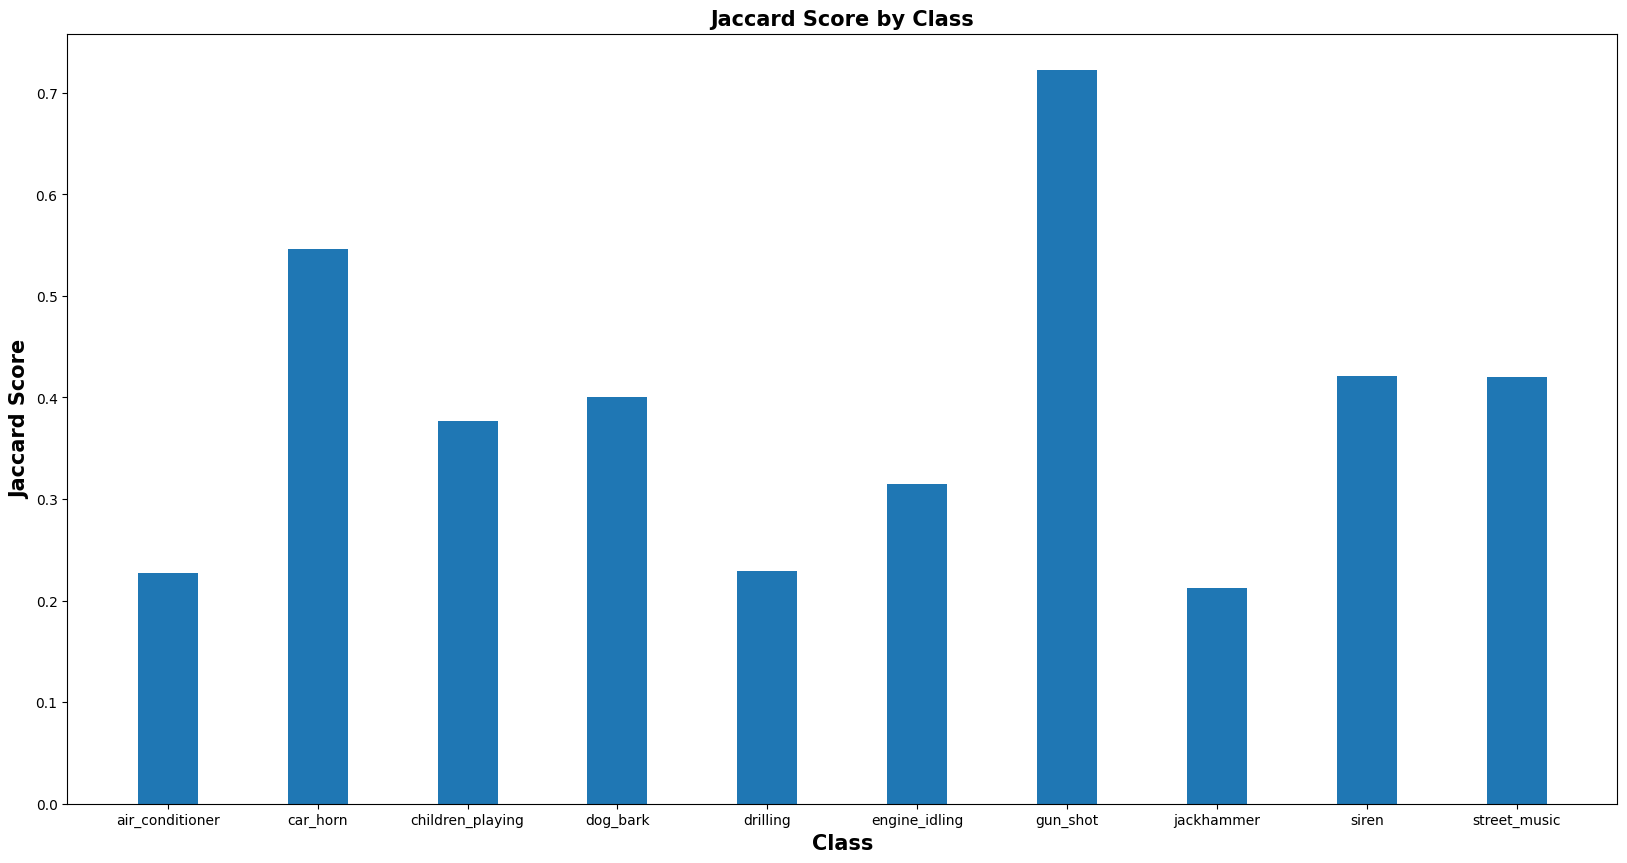

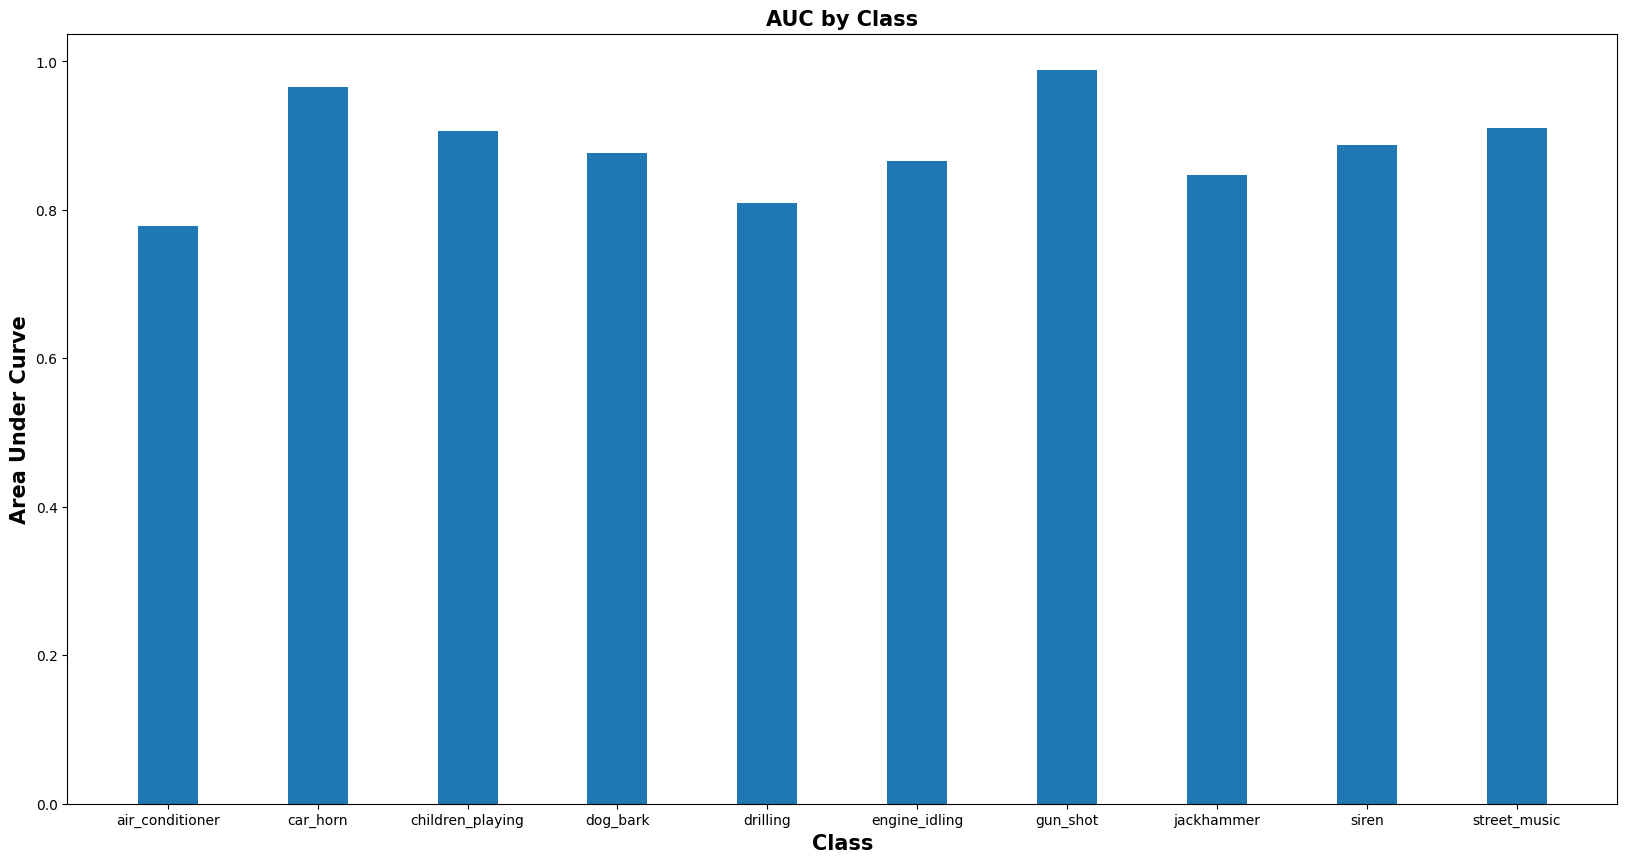

In [9]:
# transforming the label and prediction data so we can use them
predictions_rnn = []
labels_rnn = []
prob_rnn = []
for fold in range(len(prediction_rnn)):
  for line in range(len(prediction_rnn[fold])):
    prob_rnn.append(prediction_rnn[fold][line])
    predictions_rnn.append(np.argmax(prediction_rnn[fold][line]))
    labels_rnn.append(np.argmax(label_rnn[fold][line]))
predictions_rnn = np.array(predictions_rnn)
labels_rnn = np.array(labels_rnn)

# confusion matrix of all models
plt.figure(figsize=(20, 10))
class_labels = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']
s = heatmap(confusion_matrix(labels_rnn, predictions_rnn), annot = True, cmap="crest", xticklabels = class_labels, yticklabels = class_labels)
s.set(xlabel='Prediction', ylabel='Label')
plt.show()

# classification report of all models
print(classification_report(labels_rnn,predictions_rnn))

# ballanced accuracy of all models
print(f"Balanced Accuracy: {balanced_accuracy_score(labels_rnn,predictions_rnn)}")
print()
print()

# kappa score of all models
print(f"Cohen’s Kappa Score: {cohen_kappa_score(labels_rnn,predictions_rnn)}")
print()
print()

# jaccard score of all models by class
jaccard_scores = jaccard_score(labels_rnn,predictions_rnn, average=None)
plt.figure(figsize=(20, 10))
plt.bar(class_labels, jaccard_scores,  width = 0.4)
plt.xlabel("Class", fontweight ='bold', fontsize = 15)
plt.ylabel("Jaccard Score", fontweight ='bold', fontsize = 15)
plt.title("Jaccard Score by Class", fontweight ='bold', fontsize = 15)
plt.show()
print()
print()

# area under curve of all models by class
roc_scores = roc_auc_score(labels_rnn,prob_rnn, multi_class='ovr', average=None)
plt.figure(figsize=(20, 10))
plt.bar(class_labels, roc_scores,  width = 0.4)
plt.xlabel("Class", fontweight ='bold', fontsize = 15)
plt.ylabel("Area Under Curve", fontweight ='bold', fontsize = 15)
plt.title("AUC by Class", fontweight ='bold', fontsize = 15)
plt.show()